# Test 1 & 2: Cholesky CPU

These test capture the runtime for the Cholesky decomposition with GPRat on the CPU.
We use a fixed problem size of $32768=2^{15}$, an increasing number of tiles in $\{1,2,4,8,16,32,64,128,256,512\}$, an increasing number of cores in $\{6,12,24,48\}$, 8 regressors and loop 10 times.
Note that we do not account for the time it takes to return the data to the callee.

Findings:

- There is no optimal number of cores. Therefore, we will use 48 cores for the other tests.
- ...

In [2]:
# setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import utils
import math

import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams.update({'font.size': 11})
mpl.rcParams.update({'errorbar.capsize': 7})
mpl.rcParams.update({'grid.linewidth': 0.5})
mpl.rcParams.update({"legend.fontsize": 9})
mpl.rcParams.update({"lines.markersize": 6})

def figsize(x,y,y_log_min=1, y_log_max=1):
    '''
    Set figsize based on same bounding box to achive shared axes
    '''
    x_const = 0.5421892781575521
    y_const = 0.8417361111111108
    return x+x_const, (y+math.log10(y_log_max)-math.log10(y_log_min))*0.8+y_const

# bbox = ax.get_position()
# fig_width, fig_height = fig.get_size_inches()
# print((1 - (bbox.x1 - bbox.x0)) * fig_width, (1 - (bbox.y1 - bbox.y0)) * fig_height)

In [3]:
# load data

apex_dir_cholesky = "./data/1"
apex_dir_steps = "./data/2"

names_cholesky = [
    "cholesky"
]

names_steps = [
    "cholesky_step assembly",
    "cholesky_step cholesky",
    "assemble K_tiles",
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
]

file_headers = [
    "n_cores",
    "n_train",
    "n_tiles",
    "n_reg",
    "n_loops"
]

def apex_files_to_df(dir, names):
    data = []
    for filename in os.listdir(dir):
        if filename.endswith(".csv"):
            parts = filename.replace("apex_profiles_", "").replace(".csv", "").split("_")
            file_params = dict(zip(file_headers, map(int, parts)))
            file_path = os.path.join(dir, filename)
            df = pd.read_csv(file_path)
            df = df[df['name'].isin(names)]
            for key, value in file_params.items():
                df[key] = value
            data.append(df)
    df_combined = pd.concat(data, ignore_index=True)
    df_combined = df_combined.sort_values(by='n_tiles')
    return df_combined

df_cholesky = apex_files_to_df(apex_dir_cholesky, names_cholesky)
df_steps = apex_files_to_df(apex_dir_steps, names_steps)

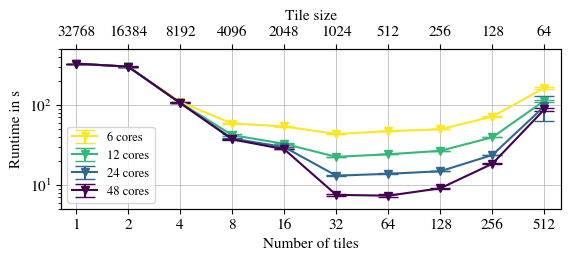

In [4]:
# plot for cholesky

n_train = 32768

fig, ax = plt.subplots(figsize=figsize(5,2))
ax_top = ax.twiny()

xticks = df_cholesky["n_tiles"].unique()
tile_sizes = n_train / xticks
ax.set_xlabel("Number of tiles")
ax.set_ylabel("Runtime in s")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(which="both")
ax.grid(False, which="minor")
ax.set_xlim(0.82, 640)
ax.set_ylim(5, 500)

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

cmap = plt.get_cmap("viridis_r")
colors = cmap(np.linspace(0, 1, df_cholesky["n_cores"].nunique()))

for (n_cores, group), color in zip(df_cholesky.groupby("n_cores"), colors):
    err = utils.confidence_error(group, 0.95)
    plt.errorbar(group['n_tiles'], group['mean']/10**9, yerr=err/10**9, label=f"{n_cores} cores", marker='v', color=color)

plt.legend()
plt.tight_layout(pad=0.1)
plt.savefig("./pdf/cholesky-cpu.pdf")

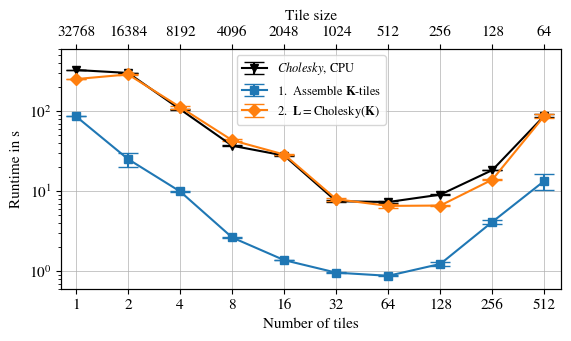

In [5]:
# plot for cholesky steps

n_train = 32768
n_cores = 48

fig, ax = plt.subplots(figsize=figsize(5, 3))

ax.set_xlabel("Number of tiles")
ax.set_ylabel("Runtime in s")
ax.set_ylim(6*10**(-1), 6*10**2)
ax.set_xlim(0.82, 640)

xticks = df_steps["n_tiles"].unique()
tile_sizes = n_train / xticks

ax_top = ax.twiny()

xticks = df_cholesky["n_tiles"].unique()
tile_sizes = n_train / xticks

ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(which="both")
ax.grid(False, which="minor")

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

df_cholesky_48 = df_cholesky[df_cholesky["n_cores"] == n_cores]
err = utils.confidence_error(df_cholesky_48, 0.95)
ax.errorbar(
    df_cholesky_48["n_tiles"],
    df_cholesky_48["mean"] / 10**9,
    yerr=err / 10**9,
    color="black",
    label=r"$\it{Cholesky}$, CPU",
    marker="v",
)

names = [
    "cholesky_step assembly",
    "cholesky_step cholesky",
]

colors = [
    "tab:blue",
    "tab:orange",
]
legend = [
    r"1.  Assemble $\mathbf{K}$-tiles",
    r"2.  $\mathbf{L} = \text{Cholesky}(\mathbf{K})$",
]
markers = ["s", "D"]

for name, label, color, marker in zip(names, legend, colors, markers):
    df_name = df_steps[df_steps["name"] == name]
    df_name["mean"] = df_name["mean"].values
    err = utils.confidence_error(df_name, 0.95)
    ax.errorbar(
        df_name["n_tiles"],
        df_name["mean"] / 10**9,
        yerr=err / 10**9,
        color=color,
        label=label,
        marker=marker,
    )

ax.legend()
fig.tight_layout(pad=0.1)
fig.savefig("./pdf/cholesky-cpu-steps.pdf")

1     86114306407
49    23911407888
22     7551247949
43     2376031067
36      671647648
15      155124501
54       38420192
63        9473090
8         2335638
29         581789
Name: mean, dtype: int64


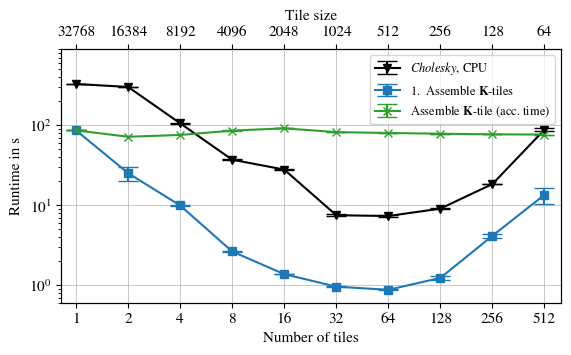

In [7]:
# plot for cholesky: Assembly

n_train = 32768
n_cores = 48

fig, ax = plt.subplots(figsize=figsize(5, 3, 6, 9))
ax_top = ax.twiny()

xticks = df_cholesky["n_tiles"].unique()
tile_sizes = n_train / xticks
ax.set_xlim(0.82, 640)
ax.set_ylim(6*10**(-1), 9*10**2)
ax.set_xlabel("Number of tiles")
ax.set_ylabel("Runtime in s")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(True, which="both")
ax.grid(False, which="minor")

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

df_cholesky_48 = df_cholesky[df_cholesky["n_cores"] == n_cores]
err = utils.confidence_error(df_cholesky_48, 0.95)
plt.errorbar(
    df_cholesky_48["n_tiles"],
    df_cholesky_48["mean"] / 10**9,
    yerr=err / 10**9,
    color="black",
    label=r"$\it{Cholesky}$, CPU",
    marker="v",
)

df_step_assembly = df_steps[df_steps["name"] == "cholesky_step assembly"]
err = utils.confidence_error(df_step_assembly, 0.95)
plt.errorbar(
    df_step_assembly["n_tiles"],
    df_step_assembly["mean"] / 10**9,
    yerr=err / 10**9,
    label=r"1.  Assemble $\mathbf{K}$-tiles",
    marker="s",
)

names_blas = [
    "assemble K_tiles",
]
names_steps_legend = [
    "Assemble tiles",
]

for i, (name, legend_name) in enumerate(zip(names_blas, names_steps_legend)):
    df_name = df_steps[df_steps["name"] == name]
    df_name["acc_stddev"] = np.sqrt(df_name["stddev"]**2 * df_name["num samples/calls"] / df_name["n_loops"])
    err = utils.confidence_error(df_name, 0.95, "acc_stddev")
    plt.errorbar(
        df_name["n_tiles"],
        df_name["mean"] / 10**9 * df_name["num samples/calls"] / 10,
        yerr=err / 10**9,
        label=r'Assemble $\mathbf{K}$-tile (acc. time)',
        color="tab:green",
        marker="x"
    )
    print(df_name["mean"])

plt.legend()
plt.tight_layout(pad=0.1)
plt.savefig("./pdf/cholesky-cpu-assembly.pdf")

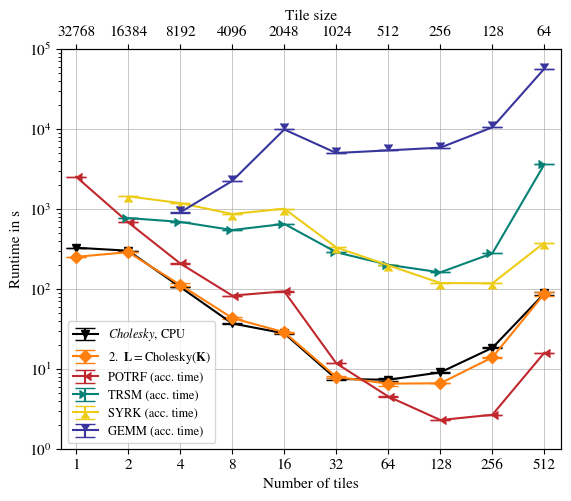

In [9]:
# plot for cholesky BLAS

n_train = 32768
n_cores = 48

fig, ax = plt.subplots(figsize=figsize(5, 5))
ax_top = ax.twiny()

xticks = df_cholesky["n_tiles"].unique()
tile_sizes = n_train / xticks
ax.set_xlim(0.82, 640)
ax.set_ylim(10**0, 10**5)
ax.set_xlabel("Number of tiles")
ax.set_ylabel("Runtime in s")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(True, which="both")
ax.grid(False, which="minor")

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

df_cholesky_48 = df_cholesky[df_cholesky["n_cores"] == n_cores]
err = utils.confidence_error(df_cholesky_48, 0.95)
plt.errorbar(
    df_cholesky_48["n_tiles"],
    df_cholesky_48["mean"] / 10**9,
    yerr=err / 10**9,
    color="black",
    label=r"$\it{Cholesky}$, CPU",
    marker="v",
)

name = "cholesky_step cholesky"
label = r"2.  $\mathbf{L} = \text{Cholesky}(\mathbf{K})$"
err = utils.confidence_error(df_steps[df_steps["name"] == name], 0.95)
plt.errorbar(
    df_steps[df_steps["name"] == name]["n_tiles"],
    df_steps[df_steps["name"] == name]["mean"] / 10**9,
    yerr=err / 10**9,
    label=f"{label}",
    color="tab:orange",
    marker="D",
    )

names_blas = [
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
]
names_steps_legend = [
    r"POTRF (acc. time)",
    r"TRSM (acc. time)",
    r"SYRK (acc. time)",
    r"GEMM (acc. time)",
]
colors = [
    "#c1282e",
    "#068176",
    "#edcc18",
    "#38369c",
]
markers = [4,5,6,7]

for name, legend_name, color, marker in zip(names_blas, names_steps_legend, colors, markers):
    df_name = df_steps[df_steps["name"] == name]
    df_name["acc_stddev"] = np.sqrt(df_name["stddev"]**2 * df_name["num samples/calls"] / df_name["n_loops"])
    err = utils.confidence_error(df_name, 0.95)
    plt.errorbar(
        df_steps[df_steps["name"] == name]["n_tiles"],
        df_steps[df_steps["name"] == name]["mean"]
        / 10**9
        * df_steps[df_steps["name"] == name]["num samples/calls"],
        yerr=err / 10**9,
        label=f"{legend_name}",
        color=color,
        marker=marker,
    )

plt.legend(loc="lower left")
plt.tight_layout(pad=0.1)
plt.savefig("./pdf/cholesky-cpu-blas.pdf")